# Decision Tree Calssifier:

#### Dataset is only using csv file. 
- only handles missing values

In [8]:
#imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [12]:
#reading csv files from download
df = pd.read_csv('../../data/data/train-metadata.csv', low_memory=False)
missing_percentages = (df.isnull().sum() / len(df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df= df[columns_to_keep]
skin_cancer_df = skin_cancer_df.fillna(skin_cancer_df.mode().iloc[0])
skin_cancer_df.shape

# Separate features (X) and target (y)
X = skin_cancer_df.drop(columns=['target'])  # Replace 'target' with your actual column name
y = skin_cancer_df['target']

# Check for non-numeric columns
non_numeric_columns = X.select_dtypes(include=['object']).columns
# (encode the non-numeric data into numeric values using)

# Initialize a LabelEncoder to assign an integer to each category.
label_encoders = {}
# Encode each non-numeric column
for column in non_numeric_columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le 

Non-numeric columns: Index(['isic_id', 'patient_id', 'sex', 'anatom_site_general', 'image_type',
       'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple',
       'attribution', 'copyright_license', 'iddx_full', 'iddx_1'],
      dtype='object')


In [18]:
# Distribution of the target variable
skin_cancer_df['target'].value_counts()

# not balanced since there are more counts of 0 than 1 -> maybe struggle to learn from minorityÍ

target
0    400666
1       393
Name: count, dtype: int64

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# "skin_cancer_decisiontree" is instantiated as an "object" of DecisionTreeClassifier "class". 
# The class_weight='balanced' parameter automatically adjusts the weight of each class 
# inversely proportional to its frequency in the training data:

skin_cancer_decisiontree = DecisionTreeClassifier(
    class_weight='balanced',max_depth=5, random_state=42
)


In [24]:
#use the method "fit" of the objects "my_decisiontree" along with training dataset and labels to train the model.

skin_cancer_decisiontree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [33]:
# Testing on the testing set:
y_predict = skin_cancer_decisiontree.predict(X_test)

[0 0 0 ... 0 0 0]


[Text(0.4, 0.8333333333333334, 'x[45] <= 1.5\ngini = 0.5\nsamples = 320847\nvalue = [160423.5, 160423.5]'),
 Text(0.2, 0.5, 'gini = -0.0\nsamples = 320533\nvalue = [160423.5, 0.0]'),
 Text(0.6, 0.5, 'x[23] <= -30.089\ngini = 0.0\nsamples = 314\nvalue = [0.0, 160423.5]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [0.0, 510.903]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 313\nvalue = [0.0, 159912.597]')]

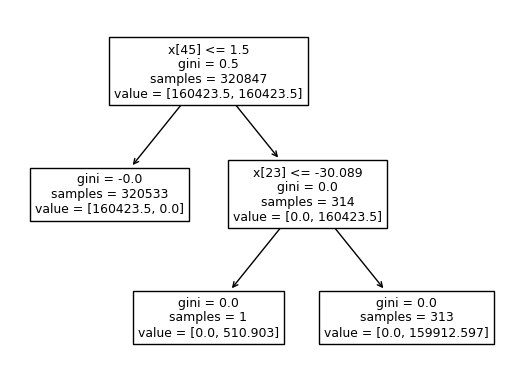

In [39]:

from sklearn import tree

tree.plot_tree(skin_cancer_decisiontree)

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80133
           1       1.00      1.00      1.00        79

    accuracy                           1.00     80212
   macro avg       1.00      1.00      1.00     80212
weighted avg       1.00      1.00      1.00     80212

Confusion Matrix:


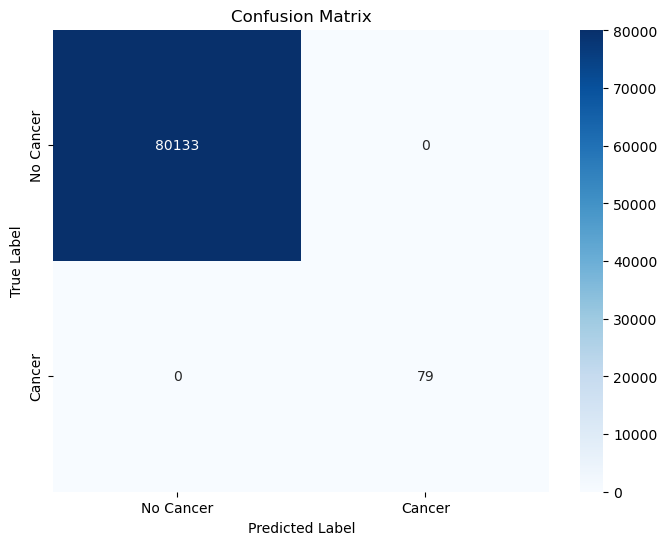

In [41]:
# Evaluate predictions
import matplotlib.pyplot as plt
import seaborn as sns
accuracy = accuracy_score(y_test, y_predict)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_predict))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()